# Binary Signal Recovery Using the Metropolis-Hastings Algorithm

## Introduction

This project aims to recover a binary signal $ \theta $ from noisy observations $ y $ using Markov Chain Monte Carlo (MCMC) techniques, specifically the Metropolis-Hastings algorithm. The goal is to recover the unknown vector $ \theta $ using the observations $ (X, y) $ and the Metropolis-Hastings to find the value of the vector that minimizes $\mathcal{H}(X, y; \theta)$ and explore how the mean squared error (MSE) varies with the number of measurements $ m $

## Problem Definition

### Signal Model

The problem is formulated as follows:

- Let $ X \in \mathbb{R}^{m \times d} $ be a measurement matrix with i.i.d. entries sampled from $ N(0, 1) $.
- Let $ \xi \in \mathbb{R}^m $ be a noise vector independent of $ X $ with i.i.d. entries sampled from $ N(0, 1) $.
- Let $ \theta \in \{0, 1\}^d $ be a binary signal chosen uniformly at random and independent of the pair $ (X, \xi) $.

The observation vector $ y $ is generated as:

$ y = X\theta + \xi $



In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def generate_data(m, d):
    X = np.random.normal(0, 1, (m, d))  #Generate the X matrix with standard normal distribution
    theta = np.random.choice([0, 1], d)  #Generate theta signal vector with binary values
    xi = np.random.normal(0, 1, m)  #Generate the noise vector xi
    y = X @ theta + xi  #Calculate the vector of measurements y
    return X, y, theta

## Maximum Likelihood Estimation

The maximum likelihood estimate (MLE) is the method you use to find the vector $\theta$ that maximizes the likelihood of the observations $y$.

The maximum likelihood estimate $ \hat{\theta} $ is given by the value of $ \theta $ that maximizes the likelihood function:

$\mathcal{L}(X, y; \theta) = \frac{\exp \left\{-\frac{1}{2} (y - X\theta)^T (y - X\theta)\right\}}{(2\pi)^{m/2}}$

which is equivalent to minimizing the function:

$\mathcal{H}(X, y; \theta) = (y - X\theta)^T (y - X\theta)$

In [7]:
def H(X, y, theta):
    return (y - X @ theta).T @ (y - X @ theta)

## Metropolis-Hastings Algorithm

The Metropolis-Hastings algorithm is used to find the estimate $ \hat{\theta} $. The stationary distribution $ \pi_{\beta}(\theta) $ is defined as:

$ \pi_{\beta}(\theta) = \frac{e^{-\beta H(X;y;\theta)}}{Z_{\beta}}, \quad \text{with} \quad Z_{\beta} = \sum_{\theta \in \Theta} e^{-\beta H(X;y;\theta)}$

$\pi_{\beta}(\theta)$ is a probability distribution over the possible states $\theta$ in your state space $\Theta$.

In this project, recovering a binary signal from noisy observations involves navigating a high-dimensional space of possible signals.

The algorithm efficiently samples from the posterior distribution $P(\theta \mid y)$ of the signal given the observed data. 

The algorithm constructs a Markov chain that has the desired distribution as its stationary distribution. This property is useful for dealing with problems where the probability landscape is complex and difficult to sample from directly.


**Structure of the Markov Chain**

State Space: The Markov chain has as its state space all possible binary vectors $\theta \in \{0, 1\}^d $.

Transitions: At each iteration, a new state $\theta^*$ is proposed by flipping a single bit of the current vector $\theta$.

Acceptance Probability: The acceptance probability $\alpha$ of the new state is calculated as:
$\alpha = \min\left(1, \frac{\pi_{\beta}(\theta^*)}{\pi_{\beta}(\theta_{t-1})}\right) = \min\left(1, \frac{e^{-\beta H(X, y; \theta^*)}}{e^{-\beta H(X, y; \theta_{t-1})}}\right)$

Iteration: These steps are repeated for a large number of iterations, generating a sequence of states $[{\theta_0, \theta_1, \ldots, \theta_N}]$.

Stationary Distribution: The stationary distribution $\pi_{\beta}(\theta)$ is the distribution to which the Markov chain converges after many iterations. This distribution represents the probability of finding the chain in a specific state $\theta$ in the long run.

In [8]:
def metropolis_hastings(X, y, beta, N, theta_init):
    d = theta_init.shape[0]
    theta = theta_init.copy()
    for t in range(N):
        i = np.random.randint(d)  #Select a random index i between 0 and d-1 (10 values)
        theta_proposal = theta.copy()
        theta_proposal[i] = 1 - theta_proposal[i]  #Propose new states by changing the current one
        #Change one value per iteration
        H_current = H(X, y, theta)  #Calculate H for the current state
        H_proposal = H(X, y, theta_proposal)  #Calculate H for the proposed state
        acceptance_ratio = min(1, np.exp(-beta * (H_proposal - H_current)))  #Calculate the acceptance ratio
        #If the proposed state has a lower H value, it is accepted.
        #We definitely update if the new H is smaller, since we want to minimize it
        if np.random.rand() < acceptance_ratio:
            theta = theta_proposal  #Accept the proposal
    return theta

$$
\xi = \mathbb{E}\left[ (\hat{\theta} - \theta)^T (\hat{\theta} - \theta) \right]
\quad\text{to check the quality of our estimate}
$$


In [9]:
def mean_squared_error(theta_true,theta_est):
    residuals = theta_est - theta_true
    return np.dot(residuals.T,residuals)

## Algorithm Procedure

1. **Initialization**: 
    - Set $ \theta_0 = \theta_{\text{init}}$.

2. **Iteration**: 
    - For $( t = 1, 2, \ldots, N-1 )$:
    
        1. Select an index $ i $ uniformly at random from $ \{1, 2, \ldots, d\} $.
        
        2. Generate a proposal $ \theta^* $ by flipping the value of the $ i $-th bit of $ \theta_{t-1} $.

        3. Compute the acceptance ratio:
            $\alpha = \min \left\{1, \frac{e^{-\beta H(X, y; \theta^*)}}{e^{-\beta H(X, y; \theta_{t-1})}} \right\}$
            
        4. Update $ \theta_t $ with: 
            $\theta_t = 
            \begin{cases} 
            \theta^* & \text{with probability} \quad \alpha \\
            \theta_{t-1} & \text{with probability} \quad 1 - \alpha
            \end{cases}$

### Finding Beta

In [10]:
d = 10  #Dimension of the signal vector
ms = range(1, 16)  #Different values of m (number of measurements)
beta = np.linspace(0.1, 3.0, 5)  #Control parameter for the Metropolis-Hastings algorithm
N = 100  #Number of iterations for the Metropolis-Hastings algorithm
M = 1000  #Number of independent realizations


In [11]:
mse_results = {}  #Calculate MSE for different values of m
mse_values = []  #List to store MSE values

#Calculate MSE for different values of beta and m
for b in beta:
    mse_values = []  #List to store MSE values for each beta
    for m in ms:
        errors = []
        for _ in range(M):
            X, y, theta_true = generate_data(m, d)  #Generate data, theta_true is what we are trying to recover
            theta_init = np.random.randint(0, 2, d)  #Randomly initialize theta
            theta_est = metropolis_hastings(X, y, b, N, theta_init)  #Estimate theta using Metropolis-Hastings
            error = mean_squared_error(theta_true, theta_est)  #Calculate mean squared error
            errors.append(error)  #Add the error to the list of errors
        mse = np.mean(errors)  #Calculate the mean of errors for the current value of m
        mse_values.append(mse)  #Add MSE to the list of MSE values
    mse_results[b] = mse_values  #Save results for the current beta

With multiple measurements, the effect of random noise $ \xi $ tends to be averaged out, making the impact of the noise less significant than the true signal $ \theta $.
This leads to an estimate of $ \theta $ that is less affected by noise fluctuations, further reducing the MSE.

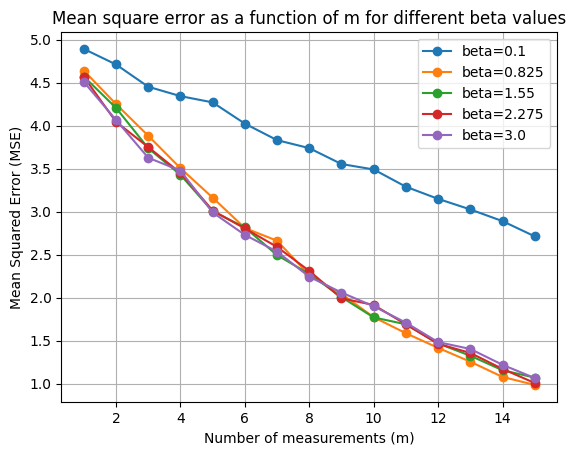

In [12]:
for b in beta:
    plt.plot(ms, mse_results[b], marker='o', label=f'beta={b}')
plt.xlabel('Number of measurements (m)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean square error as a function of m for different beta values')
plt.legend()
plt.grid(True)
plt.show()

Using $\beta = 1.0$, we proceed by running the algorithm with $M = 10000$.


In [105]:
d = 10  
ms = range(1, 16)
beta = 1.0
N = 1000 
M = 10000

In [106]:
mse_values = []  #List to store MSE values for each beta
for m in ms:
    errors = []
    for _ in range(M):
        X, y, theta_true = generate_data(m, d)  #Generate data, theta_true is what we are trying to recover
        theta_init = np.random.randint(0, 2, d)  #Randomly initialize theta
        theta_est = metropolis_hastings(X, y, beta, N, theta_init)  #Estimate theta using Metropolis-Hastings
        error = mean_squared_error(theta_true, theta_est)  #Calculate mean squared error
        errors.append(error)  #Add the error to the list of errors
    mse = np.mean(errors)  #Calculate the mean of errors for the current value of m
    mse_values.append(mse)  #Add MSE to the list of MSE values

In [ ]:
plt.plot(ms, mse_values, marker='o')
plt.xlabel('Numero di misurazioni (m)')
plt.ylabel('Errore quadratico medio (MSE)')
plt.title('Errore quadratico medio in funzione di m')
plt.grid(True)
plt.show()

In [107]:
#Determine the minimum value of m for which the MSE is sufficiently low
threshold_mse = 1.0  #Arbitrary threshold to consider the estimate reliable
reliable_m_indices = [i for i, mse in enumerate(mse_values) if mse < threshold_mse]
if reliable_m_indices:
    min_m = ms[reliable_m_indices[0]]
    print(f"Minimum value of m/d to reliably recover theta: {min_m/d:.2f}")
else:
    print("No value of m was found for which the MSE is below the threshold.")

Valore minimo di m/d per recuperare theta in modo affidabile: 0.90
